# Neuro-TabPFN (Debug Mini-Pipeline)
 - ISLES'24 -> VAE (Z) -> Mock InterSynth -> TabICL/Do-PFN
 - Objetivo causal: CATE  ≜  E[ Y|do(T=1),Z=z] - E[ Y|do(T=0),Z=z]

Este notebook implementa el pipeline completo para predecir outcomes de pacientes con stroke usando:

1. **ISLES'24**: Dataset de imágenes cerebrales 3D (máscaras de lesiones)
2. **VAE**: Comprime las imágenes 3D a vectores latentes
3. **TabPFN**: Predice outcomes clínicos
   
Orden: Config → Carga/EDA → VAE → Latentes → Mock InterSynth → TabPFN/TabICL/Do-Loss → Métricas → Guardado.

## PARTE 0: Set up inicial

### Instalación de Dependencias

In [3]:
import os
import sys

ROOT = "H:/My Drive/Debbuging Neuro"

os.chdir(ROOT)
print(sys.executable)

C:\ProgramData\anaconda3\envs\debugging\python.exe


In [4]:
%%capture
!pip install -r requirements.txt

In [5]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import zoom
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

### Configuración

In [7]:
def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seeds(42)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [8]:
class Config:
    """Configuración del pipeline"""
    HF_DATASET = "hugging-science/isles24-stroke"
    N_CASES = 50
    TARGET_SHAPE = (64, 64, 64)
    LATENT_DIM = 50
    VAE_EPOCHS = 30
    VAE_BATCH_SIZE = 4
    VAE_LR = 1e-4

    # SCM / causal
    SCM_EFFECT = 2.0
    SCM_WEIGHT_Z = 1.5
    SYN_BATCH = 8
    SYN_SEQ = 64

    # TabICL
    D_MODEL = 128
    N_LAYERS = 4
    N_HEAD = 4
    LR_TABICL = 1e-3

cfg = Config()    

## PARTE 1: CARGA Y EXPLORACIÓN DE DATOS

ISLES'24 contiene imágenes médicas de **149 pacientes con stroke (derrame cerebral)**:

| Tipo de Dato | Descripción | Formato |
|--------------|-------------|---------|
| **Máscaras de lesión** | Imagen 3D binaria que muestra dónde está la lesión | NIfTI (64×64×64 voxels) |
| **CT/MRI** | Imágenes cerebrales completas | NIfTI |
| **Datos clínicos** | Edad, sexo, severidad (NIHSS), outcome (mRS) | Numéricos |

### Nosotros usamos:
- **Input**: Máscaras de lesión 3D → comprimidas a vector de 50 números
- **Target**: mRS a 3 meses (0-6, donde 0=sin síntomas, 6=muerte)

In [10]:
# Carga ISLES desde HF y downsample 64³

def load_isles_from_hf(n_cases=50, target_shape=(64,64,64)):
    ds = load_dataset(cfg.HF_DATASET, split=f"train[:{n_cases}]")
    masks = []
    clinical = {"subject_id": [], "age": [], "sex": [], "nihss_admission": [], "mrs_3month": []}
    for i, ex in enumerate(ds):
        print(f"   Procesando caso {i+1}/{n_cases}")
        mask_obj = ex.get("lesion_mask")
        if mask_obj is None: continue
        if hasattr(mask_obj, "get_fdata"): mask = mask_obj.get_fdata()
        elif hasattr(mask_obj, "numpy"): mask = mask_obj.numpy()
        else: mask = np.asarray(mask_obj)
        if mask.ndim == 4: mask = mask[...,0]
        if mask.shape != target_shape:
            factors = [t/s for t,s in zip(target_shape, mask.shape)]
            mask = zoom(mask.astype(float), factors, order=1)
        mask = (mask > 0.5).astype(np.float32)
        masks.append(mask)
        clinical["subject_id"].append(ex.get("subject_id", f"sub-{i}"))
        clinical["age"].append(ex.get("age"))
        clinical["sex"].append(ex.get("sex"))
        clinical["nihss_admission"].append(ex.get("nihss_admission"))
        clinical["mrs_3month"].append(ex.get("mrs_3month"))
    masks = np.array(masks)
    return masks, clinical


In [11]:
# Cargar datos
masks, clinical_data = load_isles_from_hf(n_cases=cfg.N_CASES, target_shape=cfg.TARGET_SHAPE)
print("Masks:", masks.shape, "mrs_3month available:", sum(x is not None for x in clinical_data["mrs_3month"]))

Resolving data files:   0%|          | 0/149 [00:00<?, ?it/s]

   Procesando caso 1/50
   Procesando caso 2/50
   Procesando caso 3/50
   Procesando caso 4/50
   Procesando caso 5/50
   Procesando caso 6/50
   Procesando caso 7/50
   Procesando caso 8/50
   Procesando caso 9/50
   Procesando caso 10/50
   Procesando caso 11/50
   Procesando caso 12/50
   Procesando caso 13/50
   Procesando caso 14/50
   Procesando caso 15/50
   Procesando caso 16/50
   Procesando caso 17/50
   Procesando caso 18/50
   Procesando caso 19/50
   Procesando caso 20/50
   Procesando caso 21/50
   Procesando caso 22/50
   Procesando caso 23/50
   Procesando caso 24/50
   Procesando caso 25/50
   Procesando caso 26/50
   Procesando caso 27/50
   Procesando caso 28/50
   Procesando caso 29/50
   Procesando caso 30/50
   Procesando caso 31/50
   Procesando caso 32/50
   Procesando caso 33/50
   Procesando caso 34/50
   Procesando caso 35/50
   Procesando caso 36/50
   Procesando caso 37/50
   Procesando caso 38/50
   Procesando caso 39/50
   Procesando caso 40/50
   Proces

### Visualización de datos

Las máscaras son **imágenes 3D binarias** donde:
- **Blanco (1)** = Tejido dañado por el stroke
- **Negro (0)** = Tejido sano

In [13]:
# %% Visualización de 3 casos (cortes + MIP)
def visualize_lesion_mask(mask, subject_id="", slice_idx=None):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    if slice_idx is None: slice_idx = [s // 2 for s in mask.shape]
        
    axes[0].imshow(mask[slice_idx[0], :, :], cmap='hot', vmin=0, vmax=1); 
    axes[0].set_title(f'Axial z={slice_idx[0]}')
    axes[1].imshow(mask[:, slice_idx[1], :], cmap='hot', vmin=0, vmax=1); 
    axes[1].set_title(f'Coronal y={slice_idx[1]}')
    axes[2].imshow(mask[:, :, slice_idx[2]], cmap='hot', vmin=0, vmax=1); 
    axes[2].set_title(f'Sagital x={slice_idx[2]}')
    
    mip = mask.max(axis=0); axes[3].imshow(mip, cmap='hot', vmin=0, vmax=1); 
    axes[3].set_title('MIP')
    
    lesion_volume = mask.sum(); 
    total_volume = mask.size; 
    perc = 100*lesion_volume/total_volume
    
    fig.suptitle(f'Máscara {subject_id} | Voxels: {lesion_volume:.0f} ({perc:.2f}%)', fontsize=14, fontweight='bold')
    
    plt.tight_layout(); 
    plt.show(); 
    
    return lesion_volume


 VISUALIZACIÓN DE MÁSCARAS DE LESIÓN

Paciente sub-stroke0001 | Outcome (mRS): 1.0


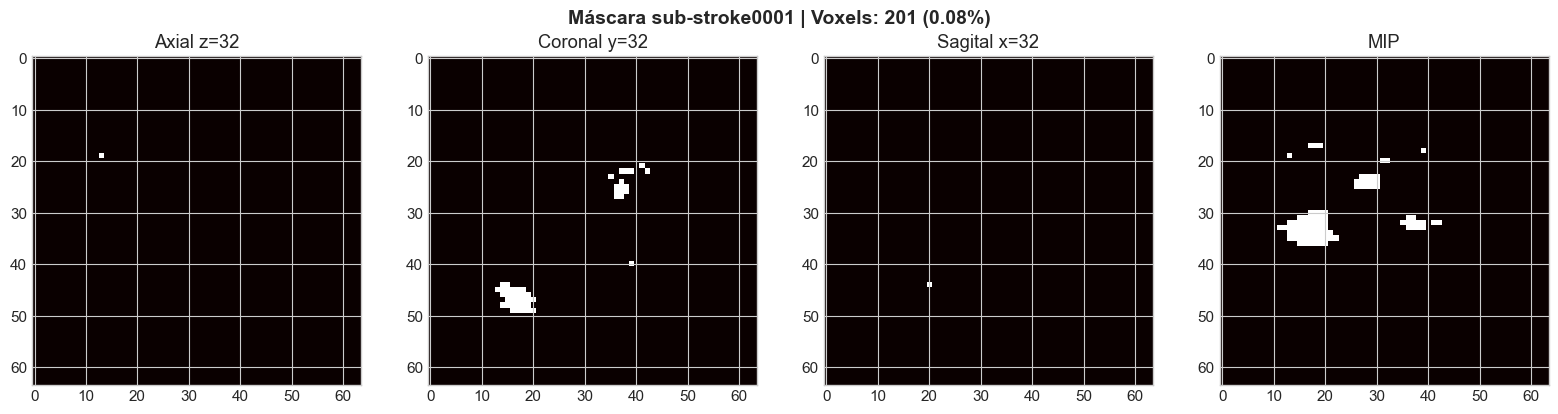


Paciente sub-stroke0002 | Outcome (mRS): 6.0


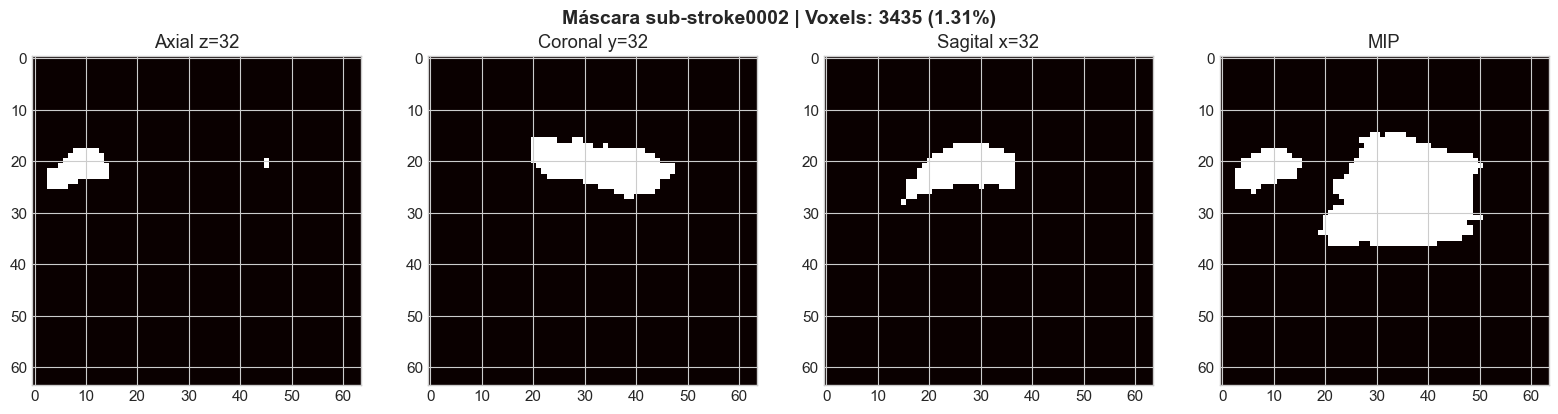


Paciente sub-stroke0003 | Outcome (mRS): 1.0


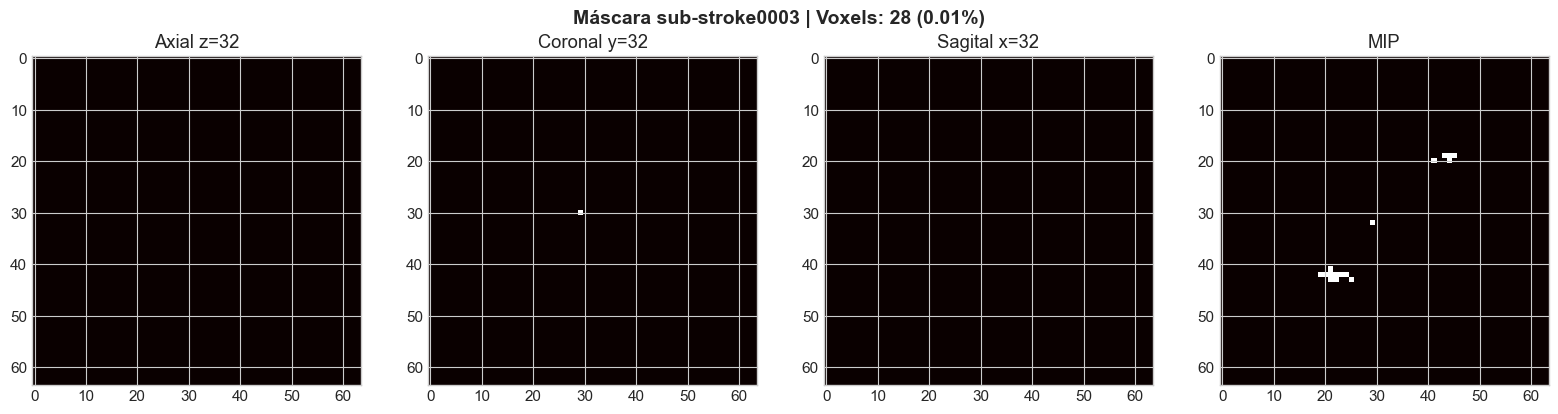

In [14]:
# Visualizar primeros 3 casos
print(" VISUALIZACIÓN DE MÁSCARAS DE LESIÓN")
print("="*60)

for i in range(min(3, len(masks))):
    sid = clinical_data['subject_id'][i]; mrs = clinical_data['mrs_3month'][i]
    print(f"\nPaciente {sid} | Outcome (mRS): {mrs}")
    visualize_lesion_mask(masks[i], sid)

In [15]:
# Crear DataFrame con datos clínicos
df_clinical = pd.DataFrame(clinical_data)

# Calcular volumen de lesión para cada paciente
df_clinical['lesion_volume'] = [m.sum() for m in masks]
df_clinical['lesion_percentage'] = df_clinical['lesion_volume'] / (64**3) * 100

print(" DATOS CLÍNICOS DE LOS PACIENTES")
print("="*60)
df_clinical.head(10)

 DATOS CLÍNICOS DE LOS PACIENTES


,subject_id,age,sex,nihss_admission,mrs_3month,lesion_volume,lesion_percentage
0,sub-stroke0001,61.0,M,5.0,1.0,201.0,0.076675
1,sub-stroke0002,85.0,F,8.0,6.0,3435.0,1.310349
2,sub-stroke0003,81.0,F,21.0,1.0,28.0,0.010681
3,sub-stroke0004,89.0,M,18.0,1.0,70.0,0.026703
4,sub-stroke0005,66.0,F,18.0,3.0,2251.0,0.858688
5,sub-stroke0006,81.0,M,21.0,2.0,3807.0,1.452255
6,sub-stroke0007,78.0,M,16.0,5.0,2260.0,0.862122
7,sub-stroke0008,54.0,M,7.0,3.0,512.0,0.195312
8,sub-stroke0009,40.0,M,9.0,1.0,330.0,0.125885
9,sub-stroke0010,98.0,F,16.0,6.0,409.0,0.156021


In [16]:
print("\n ESTADÍSTICAS DESCRIPTIVAS")
print("="*60)
df_clinical.describe().T


 ESTADÍSTICAS DESCRIPTIVAS


,count,mean,std,min,25%,50%,75%,max
age,50.0,74.060000,13.045306,40.000000,66.000000,78.000000,81.750000,98.000000
nihss_admission,50.0,11.640000,6.140398,1.000000,6.250000,10.000000,17.000000,23.000000
mrs_3month,49.0,2.224490,2.074300,0.000000,1.000000,1.000000,4.000000,6.000000
lesion_volume,50.0,1077.560059,1766.561157,16.000000,118.500000,320.500000,772.000000,8657.000000
lesion_percentage,50.0,0.411057,0.673890,0.006104,0.045204,0.122261,0.294495,3.302383


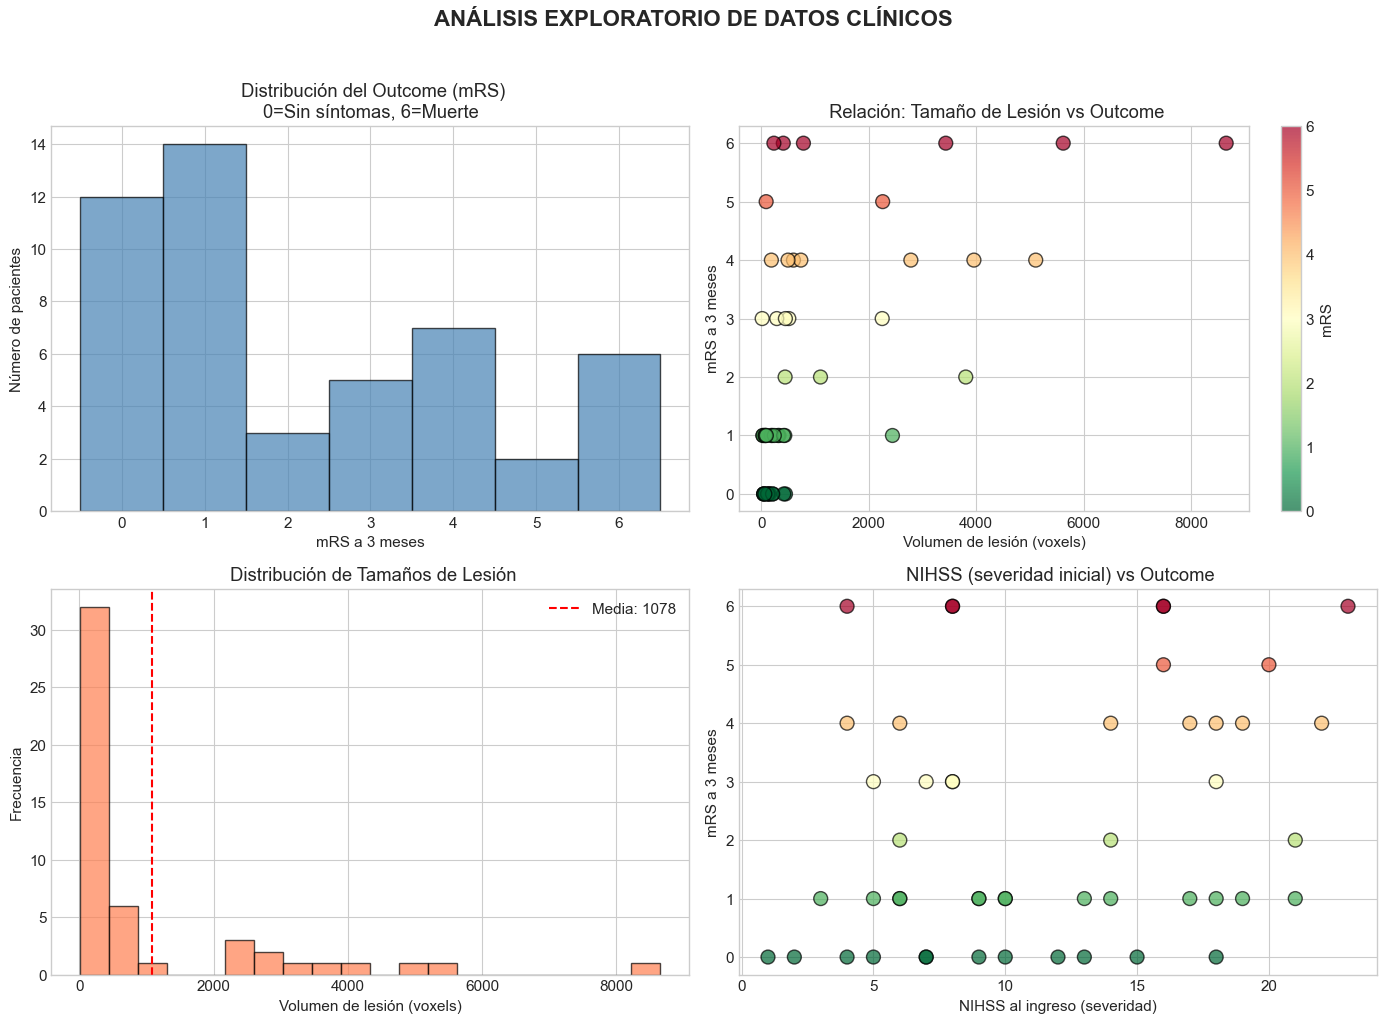

In [17]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de mRS (outcome)
mrs_values = [v for v in clinical_data['mrs_3month'] if v is not None]
colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, 7))
axes[0, 0].hist(mrs_values, bins=range(8), align='left', color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('mRS a 3 meses')
axes[0, 0].set_ylabel('Número de pacientes')
axes[0, 0].set_title(' Distribución del Outcome (mRS)\n0=Sin síntomas, 6=Muerte')
axes[0, 0].set_xticks(range(7))

# 2. Volumen de lesión vs Outcome
valid_idx = [i for i, v in enumerate(clinical_data['mrs_3month']) if v is not None]
volumes = [masks[i].sum() for i in valid_idx]
mrs_valid = [clinical_data['mrs_3month'][i] for i in valid_idx]
scatter = axes[0, 1].scatter(volumes, mrs_valid, c=mrs_valid, cmap='RdYlGn_r', 
                              s=100, alpha=0.7, edgecolors='black')
axes[0, 1].set_xlabel('Volumen de lesión (voxels)')
axes[0, 1].set_ylabel('mRS a 3 meses')
axes[0, 1].set_title(' Relación: Tamaño de Lesión vs Outcome')
plt.colorbar(scatter, ax=axes[0, 1], label='mRS')

# 3. Distribución de volúmenes de lesión
lesion_volumes = [m.sum() for m in masks]
axes[1, 0].hist(lesion_volumes, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Volumen de lesión (voxels)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title(' Distribución de Tamaños de Lesión')
axes[1, 0].axvline(np.mean(lesion_volumes), color='red', linestyle='--', label=f'Media: {np.mean(lesion_volumes):.0f}')
axes[1, 0].legend()

# 4. NIHSS vs Outcome
nihss_valid = [clinical_data['nihss_admission'][i] for i in valid_idx if clinical_data['nihss_admission'][i] is not None]
mrs_nihss = [clinical_data['mrs_3month'][i] for i in valid_idx if clinical_data['nihss_admission'][i] is not None]
if nihss_valid:
    axes[1, 1].scatter(nihss_valid, mrs_nihss, c=mrs_nihss, cmap='RdYlGn_r', 
                       s=100, alpha=0.7, edgecolors='black')
    axes[1, 1].set_xlabel('NIHSS al ingreso (severidad)')
    axes[1, 1].set_ylabel('mRS a 3 meses')
    axes[1, 1].set_title(' NIHSS (severidad inicial) vs Outcome')

plt.suptitle('ANÁLISIS EXPLORATORIO DE DATOS CLÍNICOS', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# VARIATIONAL AUTOENCODER  3D (VAE)

Comprime una imagen 3D de **262,144 voxels** (64×64×64) a un **vector de 50 números**.

```
Máscara 3D [64, 64, 64] → Encoder → Vector Z [50] → Decoder → Reconstrucción [64, 64, 64]
     262,144 valores              50 valores              262,144 valores
```

El vector Z de 50 números captura la "esencia" de la lesión (tamaño, forma, ubicación).

In [19]:
# Preparar datos para entrenamiento: Dataset para VAE
class MaskDataset(Dataset):
    def __init__(self, masks_np):
        self.m = torch.from_numpy(masks_np).float().unsqueeze(1)
    def __len__(self): return len(self.m)
    def __getitem__(self, idx): return self.m[idx]

dataset = MaskDataset(masks)
dataloader = DataLoader(dataset, batch_size=cfg.VAE_BATCH_SIZE, shuffle=True)

In [20]:
# Definición del VAE 3D

class Encoder3D(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, 4, 2, 1)
        self.conv2 = nn.Conv3d(32, 64, 4, 2, 1)
        self.conv3 = nn.Conv3d(64, 128, 4, 2, 1)
        self.conv4 = nn.Conv3d(128, 256, 4, 2, 1)
        self.bn1, self.bn2, self.bn3, self.bn4 = nn.BatchNorm3d(32), nn.BatchNorm3d(64), nn.BatchNorm3d(128), nn.BatchNorm3d(256)
        self.relu = nn.LeakyReLU(0.2)
        self.fc_mu = nn.Linear(256*4*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4*4, latent_dim)
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder3D(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4*4)
        self.deconv1 = nn.ConvTranspose3d(256, 128, 4, 2, 1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose3d(64, 32, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose3d(32, 1, 4, 2, 1)
        self.bn1, self.bn2, self.bn3 = nn.BatchNorm3d(128), nn.BatchNorm3d(64), nn.BatchNorm3d(32)
        self.relu = nn.LeakyReLU(0.2)
    def forward(self, z):
        x = self.fc(z).view(-1,256,4,4,4)
        x = self.relu(self.bn1(self.deconv1(x)))
        x = self.relu(self.bn2(self.deconv2(x)))
        x = self.relu(self.bn3(self.deconv3(x)))
        return torch.sigmoid(self.deconv4(x))

class LesionVAE(nn.Module):
    def __init__(self, latent_dim=50):
        super().__init__()
        self.encoder = Encoder3D(latent_dim)
        self.decoder = Decoder3D(latent_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + torch.randn_like(std)*std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    def encode(self, x):
        mu, _ = self.encoder(x)
        return mu

vae = LesionVAE(latent_dim=cfg.LATENT_DIM).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=cfg.VAE_LR)

print(" VAE definido")

 VAE definido


In [21]:
# Entrenar VAE
def vae_loss(recon, original, mu, logvar, beta=1.0):
    recon_loss = nn.functional.binary_cross_entropy(recon, original, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl

losses = []
for epoch in range(cfg.VAE_EPOCHS):
    vae.train(); epoch_loss=0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer_vae.zero_grad()
        recon, mu, logvar = vae(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        loss.backward(); optimizer_vae.step()
        epoch_loss += loss.item()
    avg = epoch_loss / len(dataset)
    losses.append(avg)
    if (epoch+1)%5==0: print(f"Epoch {epoch+1}/{cfg.VAE_EPOCHS} loss {avg:,.0f}")
        
print("-" * 50)
print(" Entrenamiento completado")

Epoch 5/30 loss 124,587
Epoch 10/30 loss 85,532
Epoch 15/30 loss 59,150
Epoch 20/30 loss 41,994
Epoch 25/30 loss 30,821
Epoch 30/30 loss 23,305
--------------------------------------------------
 Entrenamiento completado


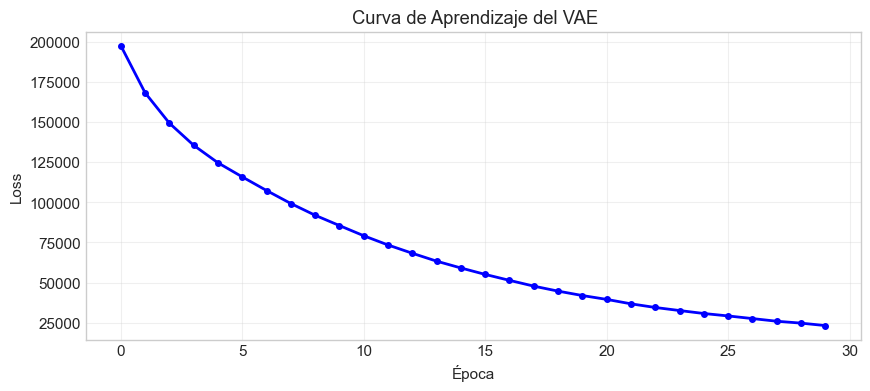

In [22]:
# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title(' Curva de Aprendizaje del VAE')
plt.grid(True, alpha=0.3)
plt.show()

## Extraer Vectores Latentes Z

In [24]:
# %% Extraer latentes Z
vae.eval()
with torch.no_grad():
    Z_list=[]
    for batch in DataLoader(dataset, batch_size=cfg.VAE_BATCH_SIZE):
        z = vae.encode(batch.to(device)).cpu()
        Z_list.append(z)
    Z = torch.cat(Z_list, dim=0).numpy()
print("Z shape:", Z.shape)

Z shape: (50, 50)


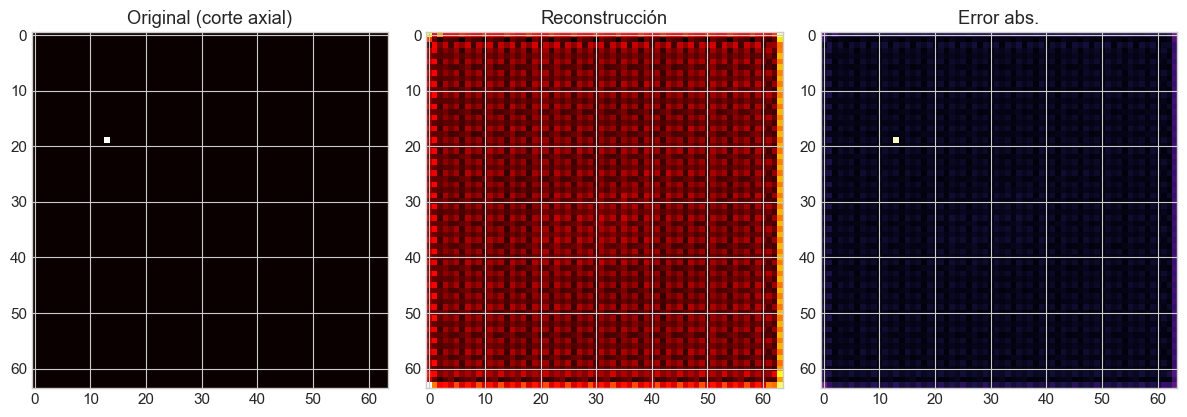

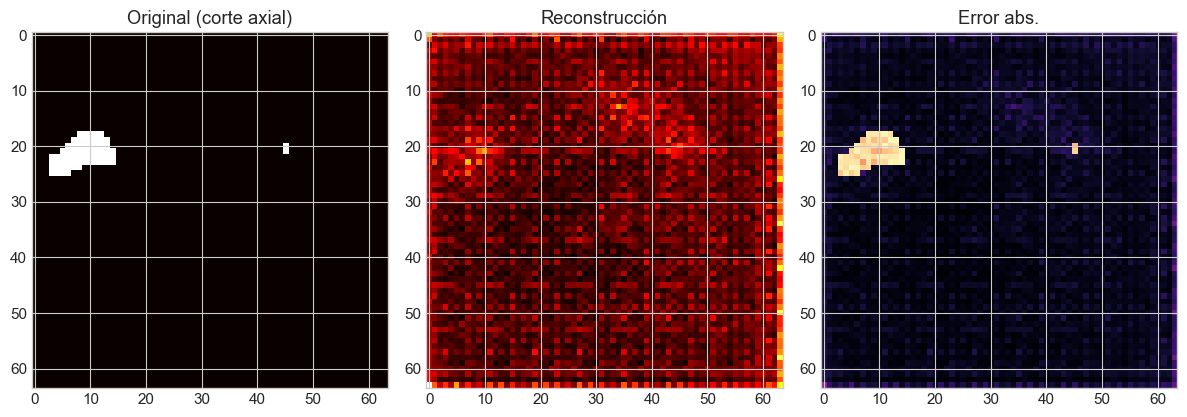

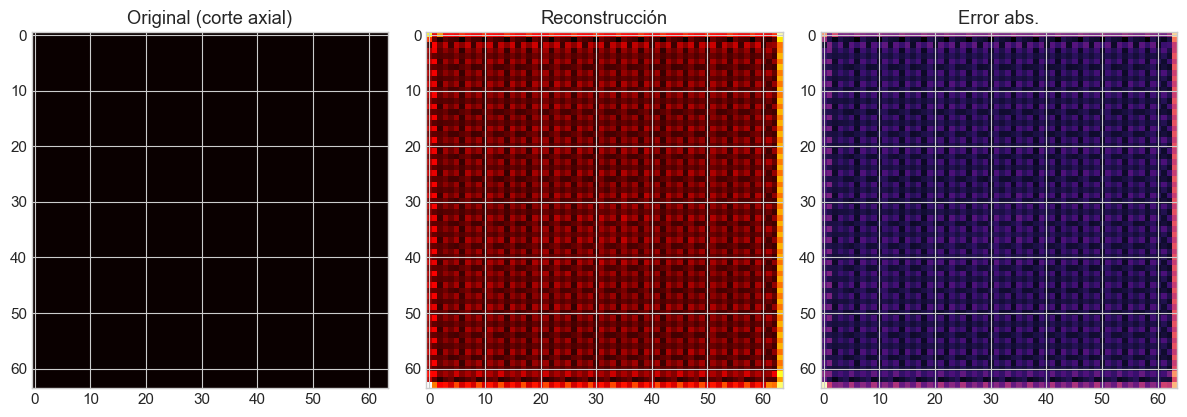

In [25]:
# %% Visualizar reconstrucciones del VAE
def visualize_reconstruction(vae, dataset, num=3):
    vae.eval()
    with torch.no_grad():
        for i in range(min(num, len(dataset))):
            x = dataset[i].unsqueeze(0).to(device)  # [1,1,64,64,64]
            recon, _, _ = vae(x)
            x_np = x.cpu().numpy()[0,0]
            r_np = recon.cpu().numpy()[0,0]
            fig, axes = plt.subplots(1, 3, figsize=(12,4))
            mid = x_np.shape[0]//2
            axes[0].imshow(x_np[mid], cmap="hot"); axes[0].set_title("Original (corte axial)")
            axes[1].imshow(r_np[mid], cmap="hot"); axes[1].set_title("Reconstrucción")
            diff = np.abs(x_np - r_np)
            axes[2].imshow(diff[mid], cmap="magma"); axes[2].set_title("Error abs.")
            plt.tight_layout(); plt.show()

visualize_reconstruction(vae, dataset, num=3)

In [26]:
# Mock InterSynth: mapa aleatorio y Y_mock por dot product
torch.manual_seed(0)
weight_map = torch.randn(*cfg.TARGET_SHAPE)
Y_mock = (torch.from_numpy(masks).float() * weight_map).sum(dim=(1,2,3)).numpy()
Y_mock = (Y_mock - Y_mock.mean()) / (Y_mock.std() + 1e-6)
print("Y_mock:", Y_mock.shape, "mean", Y_mock.mean(), "std", Y_mock.std())

Y_mock: (50,) mean 1.1920929e-08 std 0.9999999


In [27]:
# %% Conexión híbrida: genera T,Y_scm sobre Z reales
Z_real_torch = torch.from_numpy(Z).float().to(device)
logits_t = Z_real_torch[:,0]*2.0 + torch.randn_like(Z_real_torch[:,0])
prob_t = torch.sigmoid(logits_t)
T_real = torch.bernoulli(prob_t).unsqueeze(-1)          # [N,1]
Y_real_scm = cfg.SCM_EFFECT * T_real - cfg.SCM_WEIGHT_Z * Z_real_torch[:,0:1]  # [N,1]

# MiniNeuroTabPFN 

In [28]:
# %% MiniNeuroTabPFN (usa Y en contexto)
class MiniNeuroTabPFN(nn.Module):
    def __init__(self, n_features=50, d_model=128, n_layers=4, nhead=4, dropout=0.0):
        super().__init__()
        self.feature_encoder = nn.Linear(n_features + 2, d_model)  # Z + T + Y
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Linear(d_model, 1)
    def forward(self, z, t, y_masked):
        x = torch.cat([z, t, y_masked], dim=-1)   # [B,S,F+2]
        emb = self.feature_encoder(x)
        ctx = self.transformer(emb)
        return self.head(ctx)

model = MiniNeuroTabPFN(n_features=cfg.LATENT_DIM, d_model=cfg.D_MODEL,
                        n_layers=cfg.N_LAYERS, nhead=cfg.N_HEAD).to(device)
opt = optim.Adam(model.parameters(), lr=cfg.LR_TABICL)
loss_fn = nn.MSELoss()


# Generador SCM con Confounding

In [29]:
# %% Utils SCM sintético (para training y PEHE)
def make_synth_batch(batch_size=cfg.SYN_BATCH, seq_len=cfg.SYN_SEQ, n_features=cfg.LATENT_DIM, on_real_Z=None):
    if on_real_Z is None:
        z = torch.randn(batch_size, seq_len, n_features, device=device)
    else:
        N = on_real_Z.shape[0]
        idx = torch.randint(0, N, (batch_size*seq_len,), device=device)
        z = on_real_Z[idx].view(batch_size, seq_len, n_features)
    logits_t = z[:,:,0]*2.0 + torch.randn_like(z[:,:,0])
    prob_t = torch.sigmoid(logits_t)
    t = torch.bernoulli(prob_t).unsqueeze(-1)
    y = cfg.SCM_EFFECT * t - cfg.SCM_WEIGHT_Z * z[:,:,0:1]
    return z, t, y

# Do-Loss Training

In [30]:
def train_do_step(z, t, y_true, steps=1):
    model.train()
    for _ in range(steps):
        B,S,F = z.shape
        Z_ctx, Z_q = z[:,:-1,:], z[:,-1:,:]
        T_ctx = t[:,:-1,:]
        Y_ctx = y_true[:,:-1,:]
        T_q = torch.bernoulli(torch.full_like(t[:,-1:,:], 0.5))
        Y_q_true = cfg.SCM_EFFECT * T_q - cfg.SCM_WEIGHT_Z * Z_q[:,:,0:1]
        Z_in = torch.cat([Z_ctx, Z_q], dim=1)
        T_in = torch.cat([T_ctx, T_q], dim=1)
        Y_in = torch.cat([Y_ctx, torch.zeros_like(Y_q_true)], dim=1)
        pred = model(Z_in, T_in, Y_in)
        pred_q = pred[:,-1:,:]
        loss = loss_fn(pred_q, Y_q_true)
        opt.zero_grad(); loss.backward(); opt.step()
    return loss.item()


Do-step 20: loss 2.1481
Do-step 40: loss 3.0594
Do-step 60: loss 5.8015
Do-step 80: loss 3.6779
Do-step 100: loss 4.0887
Do-step 120: loss 3.2807
Do-step 140: loss 5.0179
Do-step 160: loss 2.2720
Do-step 180: loss 5.2609
Do-step 200: loss 1.8317


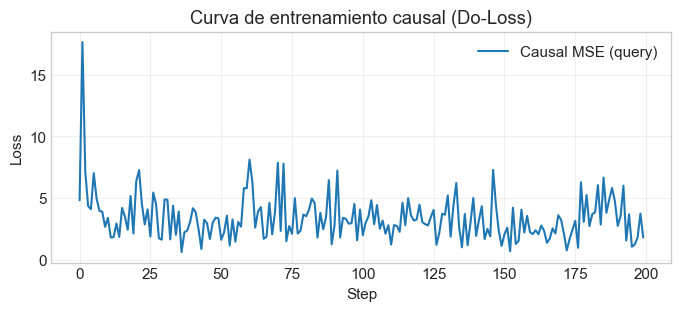

In [31]:
loss_causal=[]
for step in range(200):
    z,t,y = make_synth_batch()
    loss = train_do_step(z,t,y,steps=1)
    loss_causal.append(loss)
    if (step+1)%20==0:
        print(f"Do-step {step+1}: loss {loss:.4f}")

plt.figure(figsize=(8,3))
plt.plot(loss_causal, label='Causal MSE (query)')
plt.title('Curva de entrenamiento causal (Do-Loss)')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# Benchmark CATE

In [32]:
# %% Benchmark CATE sintético (~2.0)
@torch.no_grad()
def predict_cate(model, z_base, t_base):
    z_new = torch.randn_like(z_base[:, :1, :])
    def pred_for(tval):
        Zin = torch.cat([z_base, z_new], 1)
        Tin = torch.cat([t_base, torch.full_like(t_base[:,:1,:], tval)], 1)
        Yin = torch.zeros_like(Tin)
        out = model(Zin, Tin, Yin)
        return out[:,-1,0]
    y1 = pred_for(1.0); y0 = pred_for(0.0)
    return (y1 - y0).mean().item()

z_b,t_b,_ = make_synth_batch(batch_size=4)
cate_hat = predict_cate(model, z_b, t_b)
print(f"CATE pred (synth): {cate_hat:.3f} (esperado ~2.0)")

CATE pred (synth): 0.000 (esperado ~2.0)


# PEHE Metric

In [33]:
# %% PEHE en sintético
@torch.no_grad()
def pehe(model, batches=20):
    errs=[]
    for _ in range(batches):
        z,t,y = make_synth_batch()
        z_new = torch.randn_like(z[:,:1,:])
        Zin = torch.cat([z, z_new], 1)
        Tin1 = torch.cat([t, torch.ones_like(t[:,:1,:])], 1)
        Tin0 = torch.cat([t, torch.zeros_like(t[:,:1,:])], 1)
        Yin = torch.zeros_like(Tin1)
        y1 = model(Zin, Tin1, Yin)[:,-1,0]
        y0 = model(Zin, Tin0, Yin)[:,-1,0]
        tau_hat = y1 - y0
        tau_true = torch.full_like(tau_hat, cfg.SCM_EFFECT)
        errs.append(((tau_hat - tau_true)**2).mean().sqrt().item())
    return np.mean(errs)

pehe_s = pehe(model, batches=20)
print("PEHE (synth):", pehe_s)

PEHE (synth): 1.999843716621399


In [34]:
# %% Baseline ingenuo (regresión lineal) en Z -> Y_mock (no causal)
lin = LinearRegression().fit(Z, Y_mock)
pred_lin = lin.predict(Z)
print("Baseline Lin MSE:", mean_squared_error(Y_mock, pred_lin),
      "R2:", r2_score(Y_mock, pred_lin))

Baseline Lin MSE: 1.971611318651867e-09 R2: 1.0


In [ ]:
# Conexión con Z Reales

CATE real (latentes ISLES) mean: 0.00015073895 std: 7.550818e-05


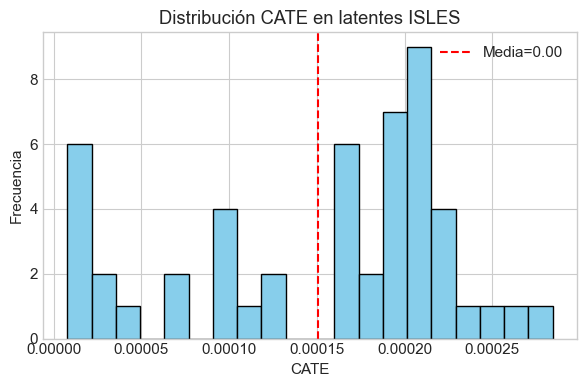

In [35]:
# %% CATE en latentes REALES (ISLES) con el modelo causal entrenado
@torch.no_grad()
def predict_cate_real(model, Z_real_np, batch_size=16):
    model.eval()
    Zr = torch.from_numpy(Z_real_np).float().to(device)  # Z reales del VAE
    N, F = Zr.shape
    cates = []
    for i in range(0, N, batch_size):
        z_batch = Zr[i:i+batch_size]                     # [B,F]
        # Tratamiento observacional sintético (si no tienes T_real)
        logits_t = z_batch[:,0]*2.0 + torch.randn_like(z_batch[:,0])
        prob_t = torch.sigmoid(logits_t)
        t_obs = torch.bernoulli(prob_t).unsqueeze(-1)    # [B,1]

        # Secuencia mínima (contexto + query)
        z_seq = torch.stack([z_batch, z_batch], dim=1)   # [B,2,F]
        t_ctx = t_obs.unsqueeze(1)                       # [B,1,1]
        t_q1 = torch.ones_like(t_ctx)                    # do(T=1)
        t_q0 = torch.zeros_like(t_ctx)                   # do(T=0)

        def run_with(t_query):
            Zin = torch.cat([z_seq[:,0:1,:], z_seq[:,1:2,:]], dim=1)
            Tin = torch.cat([t_ctx, t_query], dim=1)
            Yin = torch.zeros_like(Tin)
            out = model(Zin, Tin, Yin)
            return out[:, -1, 0]

        y1 = run_with(t_q1)
        y0 = run_with(t_q0)
        cates.append((y1 - y0).cpu())
    return torch.cat(cates, dim=0).numpy()

cate_real = predict_cate_real(model, Z)
print("CATE real (latentes ISLES) mean:", cate_real.mean(), "std:", cate_real.std())
plt.figure(figsize=(6,4))
plt.hist(cate_real, bins=20, color='skyblue', edgecolor='k')
plt.axvline(cate_real.mean(), color='r', linestyle='--', label=f"Media={cate_real.mean():.2f}")
plt.title("Distribución CATE en latentes ISLES")
plt.xlabel("CATE"); plt.ylabel("Frecuencia"); plt.legend(); plt.tight_layout(); plt.show()

In [36]:
# %% Evaluación híbrida (Z reales + SCM labels)
@torch.no_grad()
def eval_hybrid(model, Z_real_np, batches=10):
    Zr = torch.from_numpy(Z_real_np).float().to(device)
    errs=[]
    for _ in range(batches):
        z,t,y = make_synth_batch(on_real_Z=Zr)
        z_new = torch.randn_like(z[:,:1,:])
        Zin = torch.cat([z, z_new], 1)
        Tin1 = torch.cat([t, torch.ones_like(t[:,:1,:])], 1)
        Tin0 = torch.cat([t, torch.zeros_like(t[:,:1,:])], 1)
        Yin = torch.zeros_like(Tin1)
        y1 = model(Zin, Tin1, Yin)[:,-1,0]
        y0 = model(Zin, Tin0, Yin)[:,-1,0]
        tau_hat = y1 - y0
        tau_true = torch.full_like(tau_hat, cfg.SCM_EFFECT)
        errs.append(((tau_hat - tau_true)**2).mean().sqrt().item())
    return np.mean(errs)

pehe_h = eval_hybrid(model, Z, batches=10)
print("PEHE híbrido (Z reales + SCM):", pehe_h)

PEHE híbrido (Z reales + SCM): 1.9999091863632201


In [37]:
# %% Guardar artefactos
os.makedirs("Data", exist_ok=True)
np.save("Data/latents.npy", Z)
np.save("Data/y_mock.npy", Y_mock)
torch.save(vae.state_dict(), "Data/vae_checkpoint.pt")
torch.save(model.state_dict(), "Data/tabicl_mini.pt")
print("Artefactos guardados.")

Artefactos guardados.
